In [457]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [458]:
%run -i columns.py
%run -i helper_functions.py

In [459]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()

,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [460]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [461]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [462]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [463]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    # scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [464]:
X, Y = split_X_Y(train)

In [465]:
fpnn_input_columns = X.columns
X

,Employment in services (% of total employment) (modeled ILO estimate),Employment in agriculture (% of total employment) (modeled ILO estimate),"Air transport, passengers carried","Manufacturing, value added (% of GDP)",Urban population (% of total),"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)",Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)",Employment in industry (% of total employment) (modeled ILO estimate),"Commercial bank branches (per 100,000 adults)"
205,57.484001,17.218000,2.442731e+06,12.666669,55.942000,6568.982331,70.330836,15205.354928,25.298000,28.226565
236,23.823000,68.789001,4.585720e+05,12.666669,35.193000,267.402964,4.173972,2672.936239,7.388000,2.064743
4,40.020000,41.362999,1.814317e+07,5.671519,57.434000,5378.217225,63.252933,13648.254549,18.617001,21.851423
407,51.939999,15.042000,3.606247e+06,14.914748,68.346000,7792.255871,49.600000,10476.964731,33.019001,20.456815
438,71.545998,7.259000,6.025475e+06,12.666669,88.165000,20761.228907,60.000000,23036.702831,21.195999,13.890841
...,...,...,...,...,...,...,...,...,...,...
245,61.144001,11.369000,5.381735e+07,22.219054,74.840000,16734.279369,78.788310,33309.306088,27.487000,10.255867
401,45.810001,34.919998,5.006860e+05,4.373517,41.162000,1226.678252,12.360225,641.879017,19.270000,5.510077
261,61.146000,13.104000,5.331331e+07,16.914057,79.577000,5445.965419,59.540446,26698.402447,25.750000,14.154486
84,39.067001,46.807999,3.435920e+05,14.861091,55.179000,1064.666783,23.202972,7089.716605,14.124000,13.890841


In [466]:
Y

,Perceptions of corruption,GDP per capita,Dystopia residual,Generosity,Social support,Freedom,Life expectancy
205,0.057472,0.951484,2.010541,0.319931,1.137854,0.260288,0.541452
236,0.081240,0.208240,1.851000,0.213330,0.668010,0.191840,0.467210
4,0.064130,0.878670,1.898940,0.142720,0.804340,0.357330,0.813250
407,0.081700,0.977240,2.684130,0.039360,0.431650,0.235530,0.595770
438,0.083040,1.133670,2.974680,0.042500,1.033020,0.198470,0.619040
...,...,...,...,...,...,...,...
245,0.090810,1.251420,2.353840,0.414740,0.880250,0.390310,0.623660
401,0.095665,0.305445,1.837229,0.196896,0.431883,0.380426,0.247106
261,0.183550,1.115080,3.559060,0.117350,0.714600,0.377090,0.711430
84,0.061260,0.524970,2.519800,0.226800,0.625420,0.427360,0.126980


In [467]:
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [468]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [469]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

In [470]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [471]:
X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)
mse_loss = nn.MSELoss()

In [472]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.04397546127438545
loss: 0.03596147522330284
loss: 0.03600822761654854
loss: 0.03575346991419792
loss: 0.03558965027332306
loss: 0.035468485206365585
loss: 0.03535470366477966
loss: 0.03524276241660118
loss: 0.03513220697641373
loss: 0.03502294421195984


In [473]:
import matplotlib.pyplot as plt

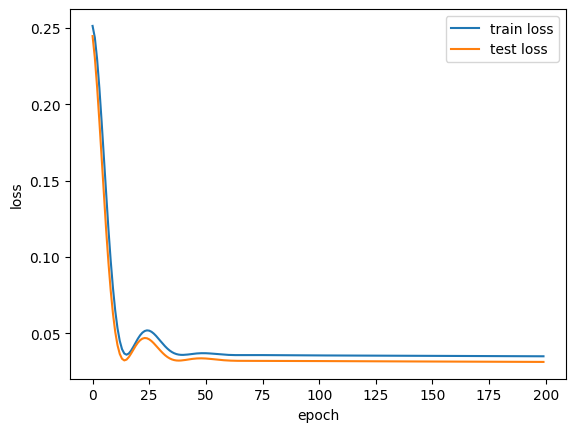

In [474]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [475]:
torch.save(model.state_dict(), 'weights/fpnn.pt')
fpnn = model

In [476]:
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

In [477]:
X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0
print(tmp)

X_start = X_end - tmp

print(X_end)
print(X_start)

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

[5.95699978 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[7.75370026e+01 9.19570007e+01 5.51234509e+08 3.52599525e+01
 1.00000000e+02 2.89389979e+06 9.59400000e+01 1.80220431e+05
 5.45550003e+01 7.05616443e+01]
[7.15800028e+01 9.19570007e+01 5.51234509e+08 3.52599525e+01
 1.00000000e+02 2.89389979e+06 9.59400000e+01 1.80220431e+05
 5.45550003e+01 7.05616443e+01]


In [478]:
y_out = model(torch.Tensor(X_scaled).to(device))

In [479]:
print(y_out.shape)

torch.Size([50, 7])


In [480]:
X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

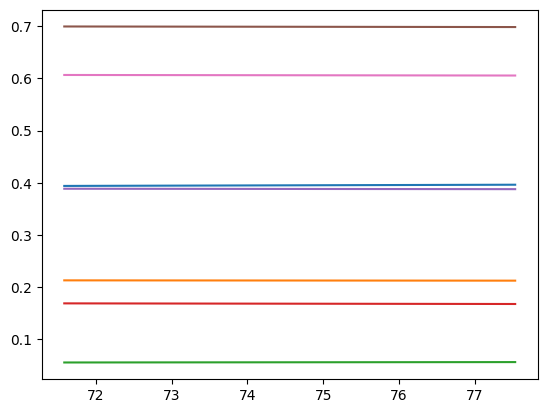

In [481]:
plt.plot(X_plot[:,0], y_plot[:, 0])
plt.plot(X_plot[:,0], y_plot[:, 1])
plt.plot(X_plot[:,0], y_plot[:, 2])
plt.plot(X_plot[:,0], y_plot[:, 3])
plt.plot(X_plot[:,0], y_plot[:, 4])
plt.plot(X_plot[:,0], y_plot[:, 5])
plt.plot(X_plot[:,0], y_plot[:, 6])

In [482]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns



In [483]:
from math import ceil
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

# data is in form one2many returns
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')
    return figure

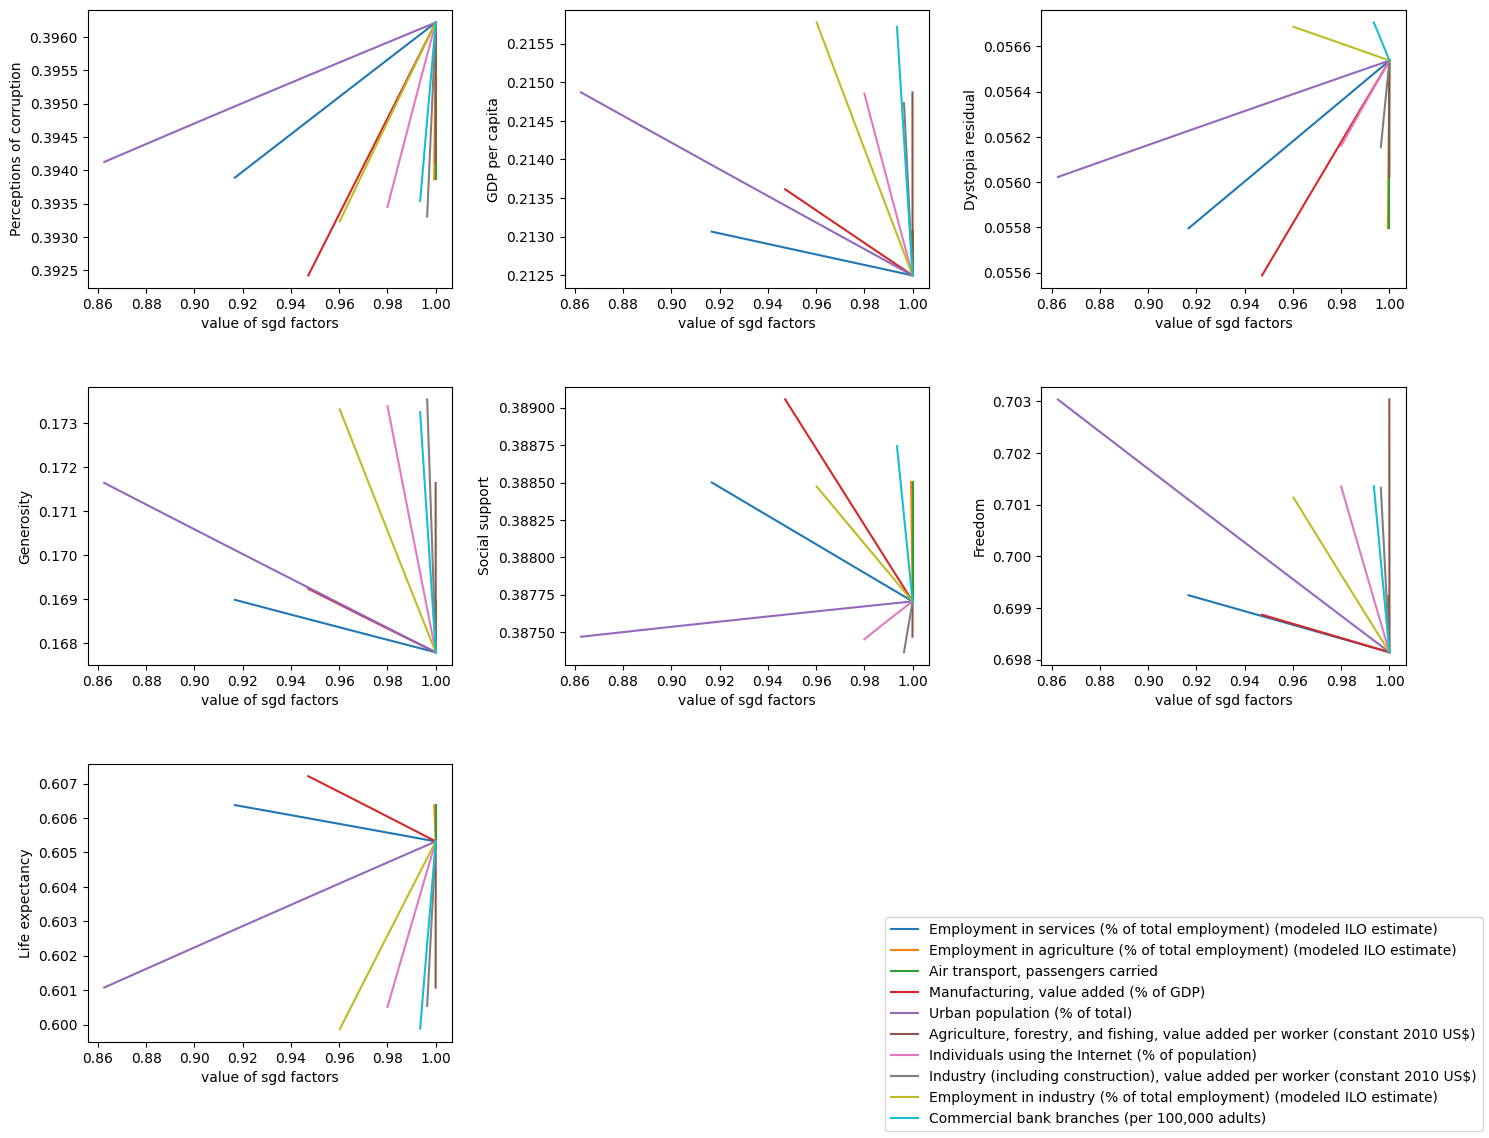

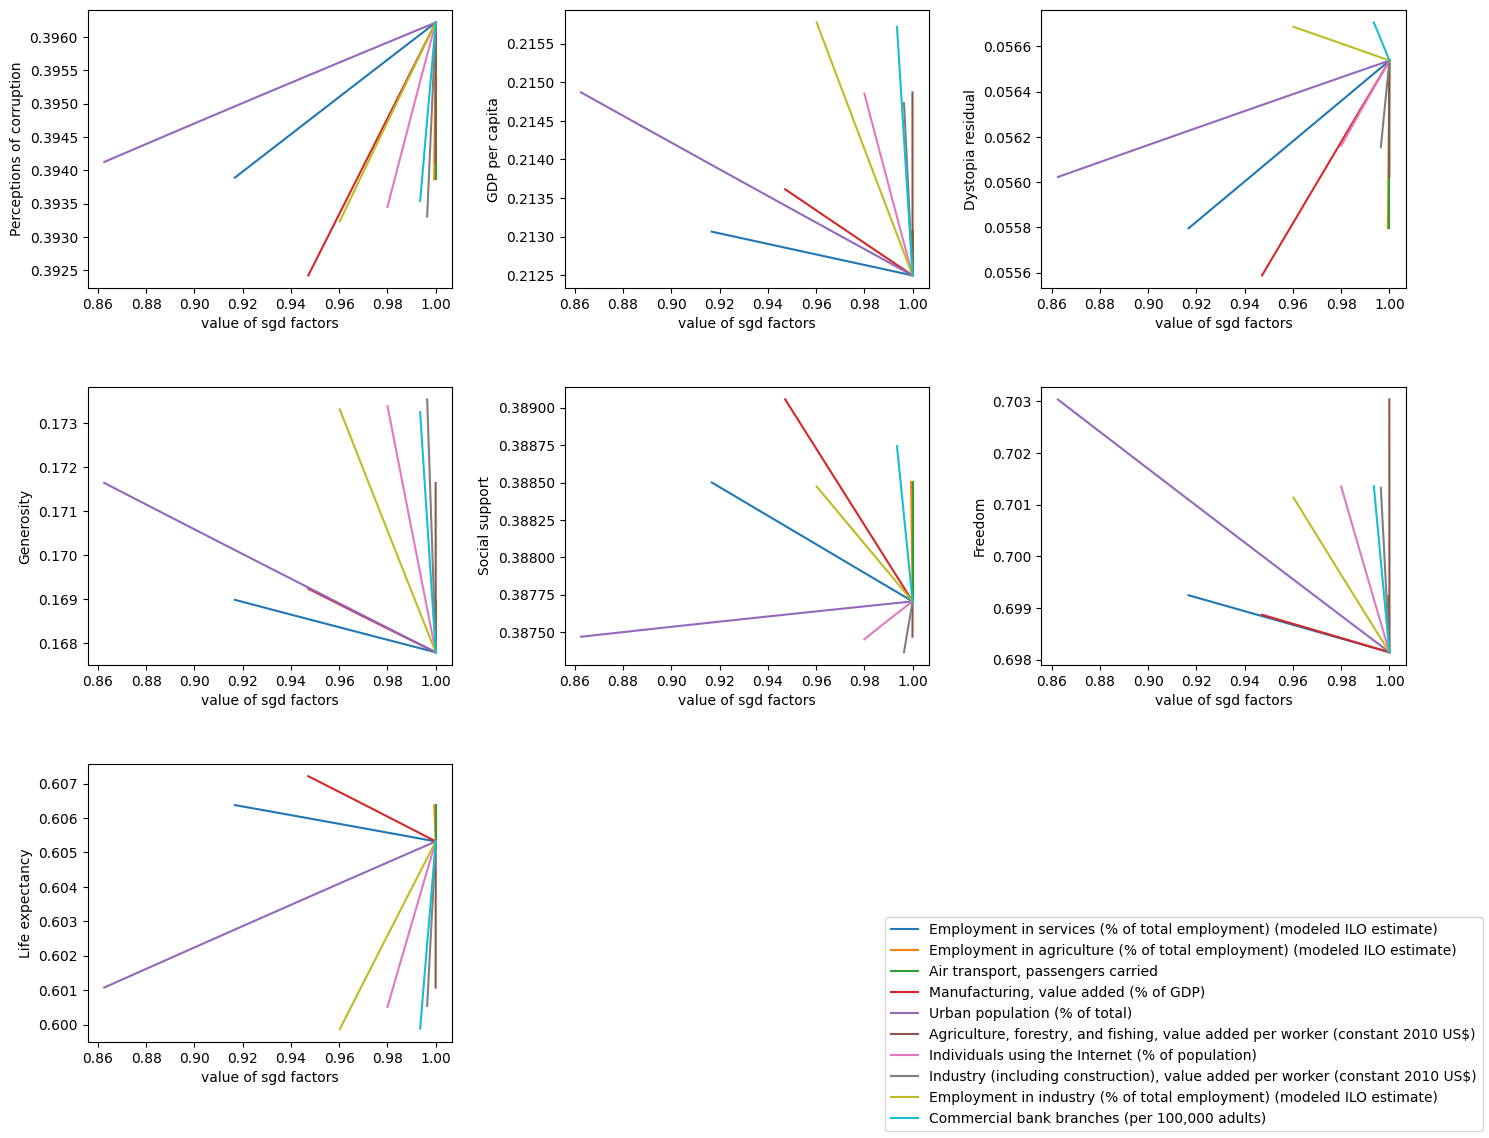

In [484]:
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

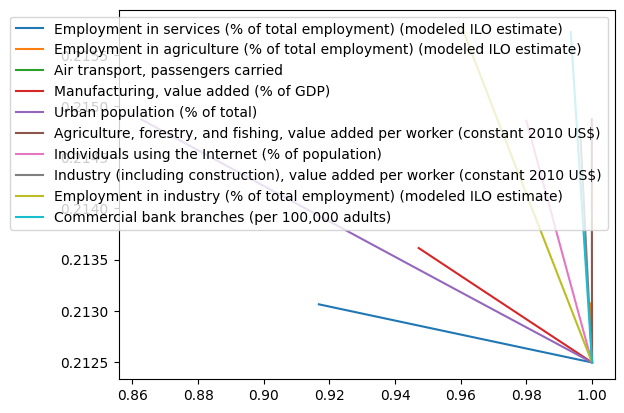

In [485]:
for i in range(len(X_columns)):
    X2plot = res[i][0]
    Y2plot = res[i][1]

    plt.plot(X2plot, Y2plot[:, 1])

plt.legend(X_columns)

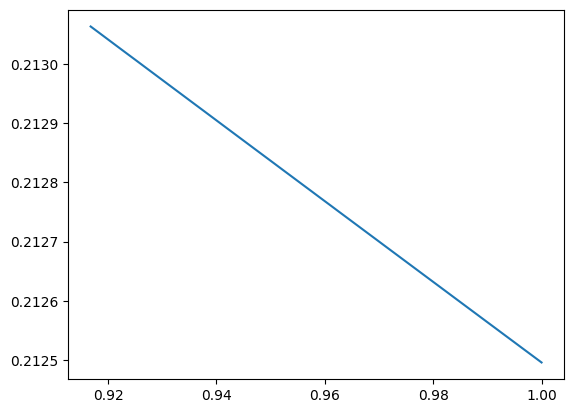

In [486]:
plt.plot(res[0][0], res[0][1][:, 1])

## Happiness Score model

In [487]:
wh_df = df.iloc[:, :12]
print(wh_df.isna().sum().sum())
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

0


,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,0.142720,1.898940


In [488]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
print(train.shape)
print(test.shape)

(411, 8)
(46, 8)


In [489]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1)), poly_transformer

In [490]:
X_train, y_train, poly_transformer = transform(train)
print(X_train.shape)
print(y_train.shape)

(411, 35)
(411, 1)


In [491]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [492]:
X_test, y_test, _ = transform(test)
y_preds = poly_model.predict(X_test)

In [493]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

6.651122753651957e-08


In [494]:
X_max = wh_df_numeric.iloc[:, 1:].max().to_numpy()
X_min = wh_df_numeric.iloc[:, 1:].min().to_numpy()

In [495]:
tmp = X_max.copy()
tmp[0] = X_min[0]

X_in = np.linspace(tmp, X_max, 50)
X_poly = poly_transformer.transform(X_in)
print(X_in.shape)
print(X_poly.shape)

preds = poly_model.predict(X_poly)
print(preds.shape)

(50, 7)
(50, 35)
(50, 1)


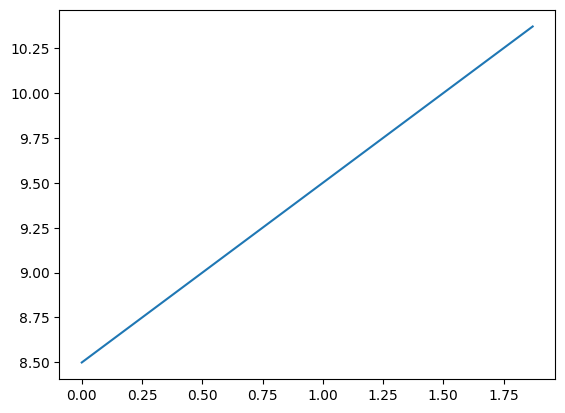

In [496]:
plt.plot(X_in[:, 0], preds[:, 0])

## Urbanization indicators modeling

In [497]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [498]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :33].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

(5260, 33)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02,NaN
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01,NaN
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06,NaN
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01,NaN
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [499]:
sgd_urban.isna().sum(axis=1)

0       13
1       10
2       10
3       28
4       28
        ..
5255     1
5256    29
5257    28
5258    29
5259     1
Length: 5260, dtype: int64

In [500]:
sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].isna().sum().sum()

233

In [501]:
shape = sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].shape
cell_total = shape[0] * shape[1]
print(cell_total)

660


In [502]:
### time series data preparing
row = sgd_urban.iloc[4, :]
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    row_numeric.shape

    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        row_numeric[i] = 0
        i += 1

    j = i + 1

    while i < row_numeric.shape[0]:
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        if i == row_numeric.shape[0]:
            break
        
        j = i
        i -= 1 

        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        # means all the values behind index i is null
        if j == row_numeric.shape[0]:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric
        
    return row

impute_row(row)

/home/chan/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/chan/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Country Name                                            Afghanistan
Country Code                                                    AFG
Indicator Name    Annual freshwater withdrawals, industry (% of ...
Indicator Code                                       ER.H2O.FWIN.ZS
1990                                                              0
1991                                                              0
1992                                                              0
1993                                                              0
1994                                                              0
1995                                                              0
1996                                                              0
1997                                                              0
1998                                                              0
1999                                                              0
2000                                            

In [503]:
sgd_imputed = sgd_urban.apply(impute_row, axis=1)

In [504]:
sgd_imputed

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.197279e+02,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,9.799884e+01,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,1.814185e+06,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01,9.862000e+01
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01,6.336000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,1.103051e+01,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03,1.580000e+03
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [505]:
indicators_ranges = {}

for indicator in URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS:
    indicator_max = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].max().max()
    indicator_min = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].min().min()
    indicators_ranges[indicator] = {
        "max": indicator_max,
        "min": indicator_min
    }

indicators_ranges

indicator = 'Air transport, freight (million ton-km)'

In [506]:
row = sgd_imputed.iloc[0, :]
def rescale_row(row):
    row_numeric = row.iloc[4:].to_numpy()
    indicator = row['Indicator Name']

    row_numeric -= indicators_ranges[indicator]['min']
    row_numeric /= indicators_ranges[indicator]['max']

    row.iloc[4:] = row_numeric

    return row

def inverse_rescale_row(row):
    row_numeric = row.iloc[4:].to_numpy()
    indicator = row['Indicator Name']

    row_numeric *= indicators_ranges[indicator]['max']
    row_numeric += indicators_ranges[indicator]['min'] 

    row.iloc[4:] = row_numeric

    return row

In [507]:
sgd_rescaled = sgd_imputed.apply(rescale_row, axis=1)

In [508]:
ipnn_indicators = list(sgd_rescaled.iloc[:20, :]['Indicator Name'])
print(ipnn_indicators)
sgd_rescaled

['Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)', 'Air transport, freight (million ton-km)', 'Air transport, passengers carried', 'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)', 'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)', 'CO2 emissions (metric tons per capita)', 'Commercial bank branches (per 100,000 adults)', "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)", "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)", 'Employment in agriculture (% of total employment) (modeled ILO estimate)', 'Employment in industry (% of total employment) (modeled ILO estimate)', 'Employment in services (% of total employment) (modeled ILO estimate)', 'Forest area (% of land area)', 'Individuals using the Internet (% of population)', 'Industry (including construction), value added per worker (con

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000318,0.000316,0.000306,0.000393,0.000375,0.000355,0.000318,0.000322,0.000321,0.000321
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,0.000044,0.000039,0.000039,0.000031,0.000058,0.000060,...,0.000459,0.000506,0.000512,0.000546,0.000396,0.000161,0.000155,0.000136,0.000118,0.000118
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,0.000061,0.000053,0.000053,0.000050,0.000060,0.000063,...,0.000456,0.000502,0.000573,0.000437,0.000514,0.000555,0.000485,0.000482,0.000467,0.000467
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168,0.989168
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585,0.006585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,0.361598,0.425346,0.474817,0.371066,0.336356,0.340053,...,0.194711,0.162542,0.161912,0.247895,0.228048,0.222253,0.209858,0.204693,0.194473,0.194473
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [509]:
## Model - encoder and decoder manner
import torch.nn as nn
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)

        self.linear2 = nn.Linear(rnn_hidden, indicators_dim)
    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = self.linear(x) 
        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)

        out, _ = self.rnn(out, (h0, c0))
        out = self.linear2(out[:, -1, :])

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [510]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

20

In [511]:
afg = sgd_imputed.iloc[:20, :]
col = afg.iloc[0:, 4:6].to_numpy(dtype=np.float32)
col
X = torch.Tensor(col).T
X.shape

torch.Size([2, 20])

In [512]:
device = torch.device('cuda')

In [513]:
data = sgd_rescaled.iloc[:, 4:].to_numpy()
# data = data.T
data = data.reshape((263, 20, 29))
data = data.transpose((0, 2, 1))

In [514]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

(210, 29, 20)
(53, 29, 20)


In [515]:
model = IndicatorPredictNN(indicators_dim, 20, 40, 10)
model.to(device)

n_epochs = 1000
lr = 0.01

# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [516]:
losses = []
test_losses = []
for epoch in range(1, n_epochs):
    optimizer.zero_grad()
    loss_total = 0

    for i in range(21):
        X = torch.Tensor(train[i*10:(i+1)*10, :28, :]).to(device)
        y = torch.Tensor(train[i*10:(i+1)*10, 28, :]).to(device)

        # print(X.shape)

        out = model(X)
        loss = criterion(out, y)

        loss.backward()

        loss_total += loss.item()
    
    optimizer.step()

    loss_total_test = 0
    for i in range(test.shape[0] // 10):
        start = i*10
        end = (i+1)*10
        if end > test.shape[0]:
            start = end - 10
        
        X_test = torch.Tensor(test[start:end, :28, :]).to(device)
        y_test = torch.Tensor(test[start:end, 28, :]).to(device)

        out = model(X_test)
        loss = criterion(out, y_test)

        loss_total_test += loss.item()


    losses.append(loss_total)
    test_losses.append(loss_total_test)
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_total))

Epoch: 10/1000............. Loss: 2.0789
Epoch: 20/1000............. Loss: 1.7692
Epoch: 30/1000............. Loss: 1.5552
Epoch: 40/1000............. Loss: 1.3642
Epoch: 50/1000............. Loss: 1.2106
Epoch: 60/1000............. Loss: 1.0863
Epoch: 70/1000............. Loss: 0.9796
Epoch: 80/1000............. Loss: 0.8914
Epoch: 90/1000............. Loss: 0.8324
Epoch: 100/1000............. Loss: 0.7412
Epoch: 110/1000............. Loss: 0.6495
Epoch: 120/1000............. Loss: 0.6094
Epoch: 130/1000............. Loss: 0.5420
Epoch: 140/1000............. Loss: 0.5083
Epoch: 150/1000............. Loss: 0.4841
Epoch: 160/1000............. Loss: 0.4467
Epoch: 170/1000............. Loss: 0.4392
Epoch: 180/1000............. Loss: 0.3992
Epoch: 190/1000............. Loss: 0.3705
Epoch: 200/1000............. Loss: 0.3762
Epoch: 210/1000............. Loss: 0.3552
Epoch: 220/1000............. Loss: 0.3376
Epoch: 230/1000............. Loss: 0.3527
Epoch: 240/1000............. Loss: 0.3235
E

In [517]:
X_test = torch.Tensor(test[:10, :28, :]).to(device)
y_test = torch.Tensor(test[:10, 28, :]).to(device)
out = model(X_test)
loss = criterion(out, y_test)
loss.item()

0.017480749636888504

In [518]:
X =  torch.Tensor(train[:10, :28, :]).to(device)
print(X.shape)
y = torch.Tensor(train[:10, 28, :]).to(device)
out = model(X)
print(out.shape)
print(y.shape)

loss = criterion(y, out)
loss

torch.Size([10, 28, 20])
torch.Size([10, 20])
torch.Size([10, 20])


tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)

Text(0.5, 1.0, 'overall')

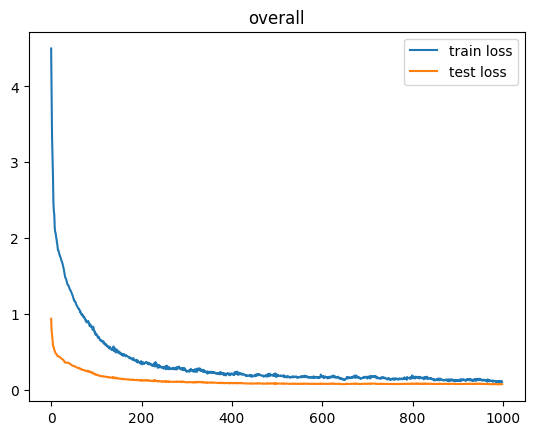

In [519]:
# total loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('overall')

Text(0.5, 1.0, 'single')

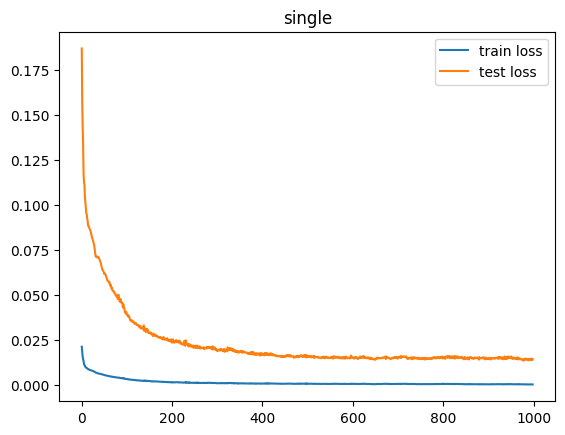

In [520]:
single_losses = np.array(losses) / 210
single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

plt.plot(single_losses)
plt.plot(single_test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('single')

In [318]:
torch.save(model.state_dict(), 'weights/ipnn.pt')
ipnn = model

In [319]:
fpnn_idx_in_ipnn = []
for index_name in fpnn_input_columns:
    fpnn_idx_in_ipnn.append(ipnn_indicators.index(index_name))  

print(fpnn_idx_in_ipnn)

[11, 9, 2, 15, 19, 0, 13, 14, 10, 6]


In [320]:
num_countries = 10

nation_slice = sgd_rescaled.iloc[:20*num_countries, :]
nation_numeric = nation_slice.iloc[:, 4:].to_numpy()
print(nation_numeric.shape)
nation_numeric = nation_numeric.reshape(num_countries, 20, 29)
print(nation_numeric.shape)
nation_numeric = nation_numeric.transpose([0, 2, 1])
print(nation_numeric.shape)

nation_numeric_tensor = torch.Tensor(nation_numeric).to(device)
# nation_slice.iloc[:, fpnn_idx_in_ipnn]
# nation_slice.apply(inverse_rescale_row, axis=1)

(200, 29)
(10, 20, 29)
(10, 29, 20)


In [321]:
preds = model(nation_numeric_tensor)

In [322]:
def onestep(X):
    y = model(X) 
    return y

In [323]:
y = onestep(nation_numeric_tensor).reshape(10, 1, 20)
print(y.shape)

torch.Size([10, 1, 20])


In [324]:
print(nation_numeric_tensor.shape)
print(y.shape)

torch.Size([10, 29, 20])
torch.Size([10, 1, 20])


In [325]:
X1 = torch.concat([nation_numeric_tensor, y], 1)
X1.shape
y1 = onestep(X1)
y1.shape

torch.Size([10, 20])

In [350]:
def getNextNYear(n, X):
    for i in range(n):
        y = model(X).reshape(10, 1, 20)
        X = torch.concat((X, y), 1)
    
    return X[:, -n:, :]
    
def getNextNYearAll(n):
    nations_total = sgd_rescaled.shape[0] // 20
    print(nations_total)

In [380]:
from math import ceil

years = 15

nations_total = sgd_rescaled.shape[0] // 20


nextYears = []

for i in range(ceil(nations_total/10)):
    start = i*10*20
    end = (i+1)*10*20

    if end > sgd_rescaled.shape[0]:
        end = sgd_rescaled.shape[0]
        start = end - 10*20

    nation_slice = sgd_rescaled.iloc[start:end, :]
    nation_numeric = nation_slice.iloc[:, 4:].to_numpy()
    nation_numeric = nation_numeric.reshape(10, 20, 29)
    nation_numeric = nation_numeric.transpose([0, 2, 1])

    X = torch.Tensor(nation_numeric).to(device)
    X_next10 = getNextNYear(years, X)

    nextYears.append({
        "start": start,
        "end": end,
        "preds": X_next10.cpu().detach().numpy()
    })
    

In [381]:
print(nextYears[-1]['preds'].shape)

(10, 15, 20)


In [392]:
newCols = []
for i in range(2019, 2019+years):
    newCols.append(str(i))

sgd_preds = sgd_rescaled.iloc[:, :4]
sgd_preds = sgd_preds.reindex(columns=list(sgd_preds.columns) + newCols)

In [398]:
for item in nextYears:
    start = item['start']
    end = item['end']
    preds = item['preds']
    preds = preds.transpose([0, 2, 1])
    preds = preds.reshape((end-start), years)
    sgd_preds.iloc[start:end, 4:] = preds

In [399]:
sgd_preds

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.002166,0.002575,0.002797,0.002965,0.003114,0.003251,0.003374,0.003484,0.003583,0.003670,0.003745,0.003806,0.003854,0.003888,0.003907
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,0.004789,0.005414,0.005580,0.005557,0.005525,0.005524,0.005539,0.005551,0.005548,0.005520,0.005460,0.005361,0.005211,0.005002,0.004722
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,0.001921,0.002813,0.003203,0.003432,0.003596,0.003709,0.003775,0.003797,0.003779,0.003722,0.003628,0.003492,0.003309,0.003073,0.002776
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.987147,0.986491,0.986683,0.986907,0.986961,0.986801,0.986424,0.985844,0.985071,0.984117,0.983000,0.981741,0.980369,0.978915,0.977417
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.011324,0.013551,0.016297,0.019520,0.022911,0.026336,0.029758,0.033159,0.036515,0.039790,0.042935,0.045901,0.048633,0.051079,0.053190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,0.205417,0.213648,0.223054,0.233570,0.244977,0.257119,0.269886,0.283218,0.297099,0.311545,0.326593,0.342297,0.358718,0.375922,0.393975
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.002359,0.007451,0.010676,0.013311,0.015662,0.017742,0.019529,0.021003,0.022158,0.023002,0.023558,0.023866,0.023979,0.023962,0.023885
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000941,0.000762,0.000463,0.000193,-0.000021,-0.000207,-0.000386,-0.000565,-0.000745,-0.000922,-0.001096,-0.001265,-0.001430,-0.001591,-0.001750
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.004140,0.004039,0.003938,0.003874,0.003837,0.003810,0.003780,0.003740,0.003687,0.003619,0.003535,0.003436,0.003322,0.003192,0.003046


In [400]:
sgd_preds_scale_back = sgd_preds.apply(inverse_rescale_row, axis=1)

In [422]:
fpnn_df = sgd_preds_scale_back[sgd_preds_scale_back['Indicator Name'].isin(fpnn_input_columns)].reset_index(drop=True)
fpnn_df

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,6.267506e+03,7.451481e+03,8.093047e+03,8.580352e+03,9.012935e+03,9.406660e+03,9.762824e+03,1.008261e+04,1.036829e+04,1.061998e+04,1.083636e+04,1.101514e+04,1.115406e+04,1.125136e+04,1.130618e+04
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,7.644474e+06,1.119387e+07,1.274540e+07,1.365669e+07,1.430657e+07,1.475893e+07,1.502214e+07,1.510809e+07,1.503414e+07,1.481021e+07,1.443463e+07,1.389404e+07,1.316644e+07,1.222573e+07,1.104532e+07
2,Afghanistan,AFG,"Commercial bank branches (per 100,000 adults)",FB.CBK.BRCH.P5,1.875510e+00,1.791901e+00,1.886760e+00,2.027978e+00,2.155636e+00,2.249458e+00,2.304557e+00,2.317799e+00,2.285132e+00,2.202600e+00,2.067292e+00,1.877785e+00,1.634055e+00,1.337372e+00,9.900373e-01
3,Afghanistan,AFG,Employment in agriculture (% of total employme...,SL.AGR.EMPL.ZS,3.726671e+01,3.581634e+01,3.419829e+01,3.258217e+01,3.100268e+01,2.945987e+01,2.795107e+01,2.647707e+01,2.504118e+01,2.364797e+01,2.230226e+01,2.100876e+01,1.977182e+01,1.859526e+01,1.748220e+01
4,Afghanistan,AFG,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,1.844957e+01,1.926858e+01,2.010675e+01,2.092804e+01,2.173276e+01,2.252864e+01,2.332074e+01,2.411022e+01,2.489553e+01,2.567369e+01,2.644106e+01,2.719373e+01,2.792776e+01,2.863937e+01,2.932499e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,Zimbabwe,ZWE,Employment in services (% of total employment)...,SL.SRV.EMPL.ZS,2.734805e+01,2.808603e+01,2.895958e+01,2.982156e+01,3.069656e+01,3.160846e+01,3.256999e+01,3.358760e+01,3.466525e+01,3.580583e+01,3.701120e+01,3.828199e+01,3.961720e+01,4.101398e+01,4.246723e+01
2626,Zimbabwe,ZWE,Individuals using the Internet (% of population),IT.NET.USER.ZS,2.734018e+01,2.805959e+01,2.849399e+01,2.883471e+01,2.913229e+01,2.941033e+01,2.968276e+01,2.996074e+01,3.025594e+01,3.058145e+01,3.095151e+01,3.138127e+01,3.188624e+01,3.248173e+01,3.318221e+01
2627,Zimbabwe,ZWE,"Industry (including construction), value added...",NV.IND.EMPL.KD,6.946337e+03,7.876038e+03,8.608160e+03,9.132109e+03,9.479378e+03,9.710906e+03,9.881531e+03,1.003292e+04,1.019612e+04,1.039450e+04,1.064603e+04,1.096489e+04,1.136260e+04,1.184880e+04,1.243168e+04
2628,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,1.163699e+01,1.210328e+01,1.263615e+01,1.323192e+01,1.387811e+01,1.456597e+01,1.528922e+01,1.604449e+01,1.683088e+01,1.764926e+01,1.850175e+01,1.939136e+01,2.032161e+01,2.129626e+01,2.231894e+01


In [424]:
fpnn_input_columns

Index(['Employment in services (% of total employment) (modeled ILO estimate)',
       'Employment in agriculture (% of total employment) (modeled ILO estimate)',
       'Air transport, passengers carried',
       'Manufacturing, value added (% of GDP)',
       'Urban population (% of total)',
       'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
       'Individuals using the Internet (% of population)',
       'Industry (including construction), value added per worker (constant 2010 US$)',
       'Employment in industry (% of total employment) (modeled ILO estimate)',
       'Commercial bank branches (per 100,000 adults)'],
      dtype='object')

In [434]:
current_order = fpnn_df.iloc[:10, :]['Indicator Name'].to_list()
wanted_order = list(fpnn_input_columns)
current_order
wanted_order

cur2wanted_mapping = []
for idx in wanted_order:
    cur2wanted_mapping.append(current_order.index(idx)) 

print(cur2wanted_mapping)

[5, 3, 1, 8, 9, 0, 6, 7, 4, 2]


Index(['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027',
       '2028', '2029', '2030', '2031', '2032', '2033'],
      dtype='object')

In [529]:
def getCountryWHPredictedFeatures(countryCode):
    country_code = countryCode
    country_data = fpnn_df[fpnn_df['Country Code'] == country_code].reset_index(drop=True)
    country_data_reordered = country_data.iloc[cur2wanted_mapping, :]
    idx2iter = country_data_reordered.columns[4:]
    idx2iter

    fpnn_preds = {}

    for idx in list(idx2iter):
        raw = country_data_reordered.loc[:, idx].to_numpy()
        scaled = X_scaler.transform(raw.reshape(1, 10))
        X = torch.Tensor(scaled).to(device)
        y = fpnn(X).cpu().detach().numpy()

        y = Y_scaler.inverse_transform(y)
        fpnn_preds[idx] = y
    
    return fpnn_preds


In [536]:
def getHappinessScore(X):
    X_poly = poly_transformer.transform(X)
    y = poly_model.predict(X_poly)
    return y

In [559]:
can_wh_preds = getCountryWHPredictedFeatures('CAN')

getHappinessScore(can_wh_preds['2025'])

array([[5.15273642]])

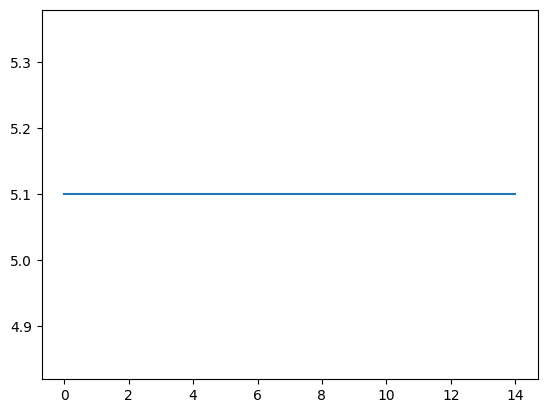

In [564]:
whc = []
for idx in can_wh_preds.keys():
    whc.append(getHappinessScore(can_wh_preds[idx])[0][0]) 

plt.plot(whc)

## Make some plots

In [328]:
for i in range(1, 1):
    print(i)

In [329]:
t = torch.Tensor(col.T)
t

tensor([[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00, 2.1345e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0678e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1177e+01],
        [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00, 1.8767e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01, 1.4214e+01, 2.8124e+01,
         2.0678e+00, 4.2932e-04, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1266e+01]])

In [330]:
t.reshape((1, 2, 20))

tensor([[[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00,
          2.1345e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.0678e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1177e+01],
         [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00,
          1.8767e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01,
          1.4214e+01, 2.8124e+01, 2.0678e+00, 4.2932e-04, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1266e+01]]])